## In this notebook, we'll prepare to deploy our FoodVision Mini model to the internet as a usable app.*

*09_model_deployment_part_2 covers creating the app and deploying it on Hugging Face.

In [ ]:
""" 0. Setting up """
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

"""
Create the going_modular folder and move in its scripts.
"""
import os

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular import data_setup, engine
  print("going_modular scripts already downloaded.")
except:
  # Get the going_modular scripts
  print("Downloading going_modular scripts...")
  !git clone https://github.com/lanehale/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  print("going_modular downloaded.")
  from going_modular import data_setup, engine

from going_modular.utils import set_seeds, plot_loss_curves, save_model
set_seeds()

print(">!ls going_modular")
!ls going_modular

device = "cuda" if torch.cuda.is_available() else "cpu"
device

[INFO] Couldn't find torchinfo... installing it.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 747, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 747 (delta 154), reused 92 (delta 92), pack-reused 572 (from 2)
Receiving objects: 100% (747/747), 18.52 MiB | 35.50 MiB/s, done.
Resolving deltas: 100% (418/418), done.
going_modular downloaded.
>!ls going_modular
data_setup.py	  get_custom_data.py  pretrained_confmat.py  utils.py
download_data.py  get_data.py	      pretrained_writer.py
engine.py	  model_builder.py    __pycache__
get_any_data.py   predict.py	      train.py


'cpu'

In [ ]:
""" 1. Getting data """
from pathlib import Path
from going_modular import download_data

# Download 20 percent training data
data_20_percent_path = download_data.from_path(from_path="pizza_steak_sushi_20_percent.zip", image_dir="pizza_steak_sushi_20_percent")

# Set up train and test directory paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

# Get all test data paths
print(f"[INFO] Collecting all filepaths ending with '.jpg' in directory: {test_dir}")
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))  # this is only used for predictions

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza_steak_sushi_20_percent data...
>!ls data/pizza_steak_sushi_20_percent
test
train

[INFO] Collecting all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


## 3. Creating an EffNetB2 feature extractor (pretrained model)

In [ ]:
# Setup pretrained EffNetB2 weights
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# Get automatic transforms
effnetb2_transforms = weights_b2.transforms()

# Set up pretrained model
effnetb2_model = torchvision.models.efficientnet_b2(weights=weights_b2)  # could also use weights="DEFAULT"

# Freeze all base layers in the "features" section of the model
for parm in effnetb2_model.features.parameters():  # can omit .features, same without it
  parm.requires_grad = False

# Check out EffNetB2 classifier head
effnetb2_model.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 88.5MB/s]


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# Update the classifier head
set_seeds()
effnetb2_model.classifier = nn.Sequential(
  nn.Dropout(p=0.3, inplace=True),  # keep dropout layer same
  nn.Linear(in_features=1408,       # keep in_features same
            out_features=3,         # change out_features to suit our number of classes
            bias=True)              # unnecessary, the bias parameter defaults to True
)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary
summary(effnetb2_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
""" 3.1 Creating a function to make an EffNetB2 feature extractor """
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 3.
      seed (int, optional): random seed value. Defaults to 42.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """
  # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all base layers in the "features" section of the model
  for parm in model.parameters():
    parm.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  set_seeds(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes)
  )

  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms_2 = create_effnetb2_model(num_classes=3,
                                                        seed=42)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
""" 3.2 Creating DataLoaders for EffNetB2 """
# Set up DataLoaders
from going_modular.data_setup import create_dataloaders

train_dataloader_b2, test_dataloader_b2, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [ ]:
""" 3.3 Training EffNetB2 feature extractor """
# Set up optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001)  # 1e-3 doesn't work as well

# Set up loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_b2,
                                test_dataloader=test_dataloader_b2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

print(f"Max test acc: {max(effnetb2_results['test_acc']):.3f} | Min test loss: {min(effnetb2_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625
Max test acc: 0.969 | Min test loss: 0.281


In [ ]:
# Reset optimizer
optimizer = torch.optim.Adam(params=effnetb2_model.parameters(),
                             lr=0.001)  # 1e-3 doesn't work as well

set_seeds()
effnetb2_model_results = engine.train(model=effnetb2_model,
                                      train_dataloader=train_dataloader_b2,
                                      test_dataloader=test_dataloader_b2,
                                      epochs=10,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      device=device)

print(f"Max test acc: {max(effnetb2_model_results['test_acc']):.3f} | Min test loss: {min(effnetb2_model_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625
Max test acc: 0.969 | Min test loss: 0.281


The two models trained exactly the same as expected (using seeds).

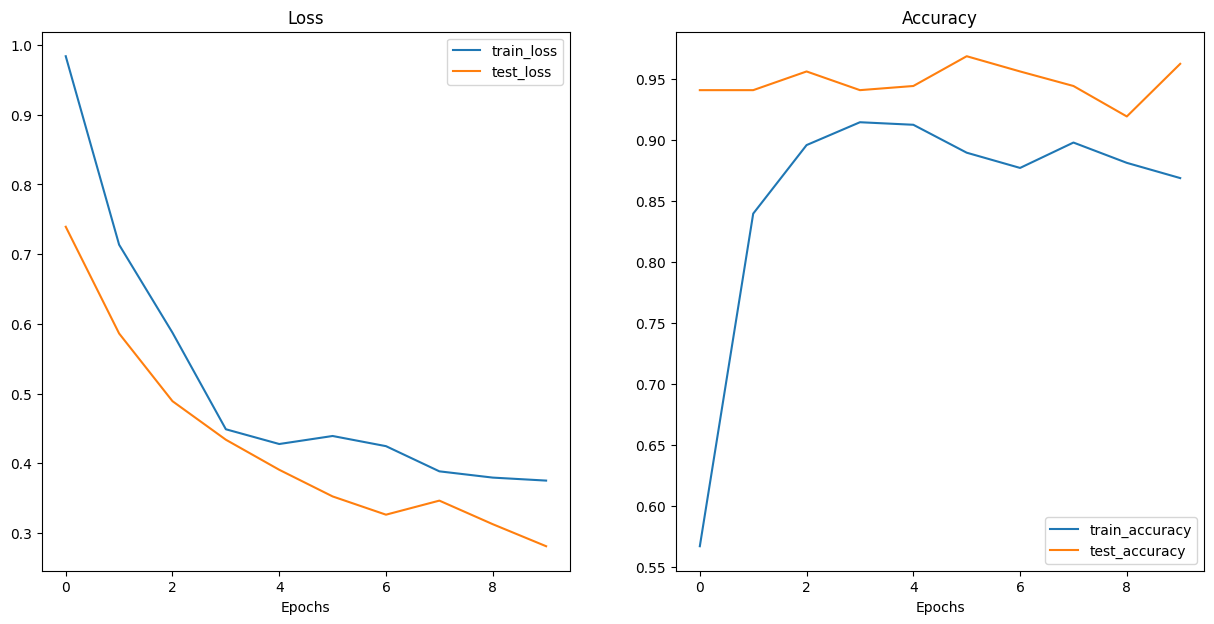

In [ ]:
""" 3.4 Inspecting EffNetB2 loss curves """
# Plot loss and accuracy curves
plot_loss_curves(effnetb2_results)

In [ ]:
""" 3.5 Saving EffNetB2 feature extractor """
# Save the model
save_model(model=effnetb2,
           target_dir="models",
           model_name="effnetb2.pth")

save_model(model=effnetb2_model,
           target_dir="models",
           model_name="effnetb2_model.pth")

[INFO] Saving model to: models/effnetb2.pth
[INFO] Saving model to: models/effnetb2_model.pth


In [ ]:
""" 3.6 Checking the size of EffNetB2 feature extractor """
# Get the model size in bytes then convert to megabytes
model_size = Path("models/effnetb2.pth").stat().st_size // (1024*1024)  # division converts bytes to megabytes (roughly)
print(f"EffNetB2 model size: {model_size} MB")

EffNetB2 model size: 29 MB


In [ ]:
""" 3.7 Collecting EffNetB2 feature extractor stats """
# Count number of parameters in EffNetB2
effnetb2_total_parms = sum(torch.numel(parm) for parm in effnetb2.parameters())
effnetb2_total_parms

7705221

In [ ]:
""" Save everything in a dictionary to make comparisons later on """
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],  # index -1 means the last element
    "test_acc": effnetb2_results["test_acc"][-1],
    "number_of_parameters": effnetb2_total_parms,
    "model_size (MB)": model_size
}
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [ ]:
# We want the best loss and accuracy; not always the last elements
effnetb2_stats["test_loss"] = min(effnetb2_results['test_loss'])
effnetb2_stats["test_acc"] = max(effnetb2_results['test_acc'])    # epoch 6 has the best accuracy in this case
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [ ]:
print(f"Max test acc: {max(effnetb2_results['test_acc']):.3f} | Min test loss: {min(effnetb2_results['test_loss']):.3f}")

Max test acc: 0.969 | Min test loss: 0.281


In [ ]:
print(f"Max test acc: {max(effnetb2_model_results['test_acc']):.3f} | Min test loss: {min(effnetb2_model_results['test_loss']):.3f}")

Max test acc: 0.969 | Min test loss: 0.281


### Train EffNetB2 using pretrained_writer.py like in chapters 6 and 7 (for some reason the results are better)

In [ ]:
from going_modular import pretrained_writer

model_effnetb2 = torchvision.models.efficientnet_b2(weights=weights_b2).to(device)

results_effnetb2, pred_list_effnetb2 = pretrained_writer.run_model_writer(
    model=model_effnetb2,
    weights=weights_b2,
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=32,
    dropout=0.3,
    in_features=1408,
    optimizer_type="Adam",
    optimizer_lr=0.001,
    num_epochs=10,
    image_data=test_image_path_list,
    device=device,
    writer=None,
    model_name="model_effnetb2"
)

Training with model model_effnetb2...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9791 | train_acc: 0.5604 | test_loss: 0.7128 | test_acc: 0.9011
Epoch: 2 | train_loss: 0.7206 | train_acc: 0.8063 | test_loss: 0.5769 | test_acc: 0.9443
Epoch: 3 | train_loss: 0.5971 | train_acc: 0.7937 | test_loss: 0.4906 | test_acc: 0.9437
Epoch: 4 | train_loss: 0.5227 | train_acc: 0.8271 | test_loss: 0.4484 | test_acc: 0.9222
Epoch: 5 | train_loss: 0.4196 | train_acc: 0.8917 | test_loss: 0.3825 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.3838 | train_acc: 0.9083 | test_loss: 0.3493 | test_acc: 0.9443
Epoch: 7 | train_loss: 0.3517 | train_acc: 0.9208 | test_loss: 0.3165 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.3706 | train_acc: 0.9062 | test_loss: 0.3061 | test_acc: 0.9534
Epoch: 9 | train_loss: 0.3070 | train_acc: 0.9396 | test_loss: 0.2988 | test_acc: 0.9597
Epoch: 10 | train_loss: 0.3613 | train_acc: 0.8958 | test_loss: 0.2692 | test_acc: 0.9750
[INFO] Total running time: 59.013 seconds
Predicting with data/pizza_steak_sushi_20_percent/test image_data..

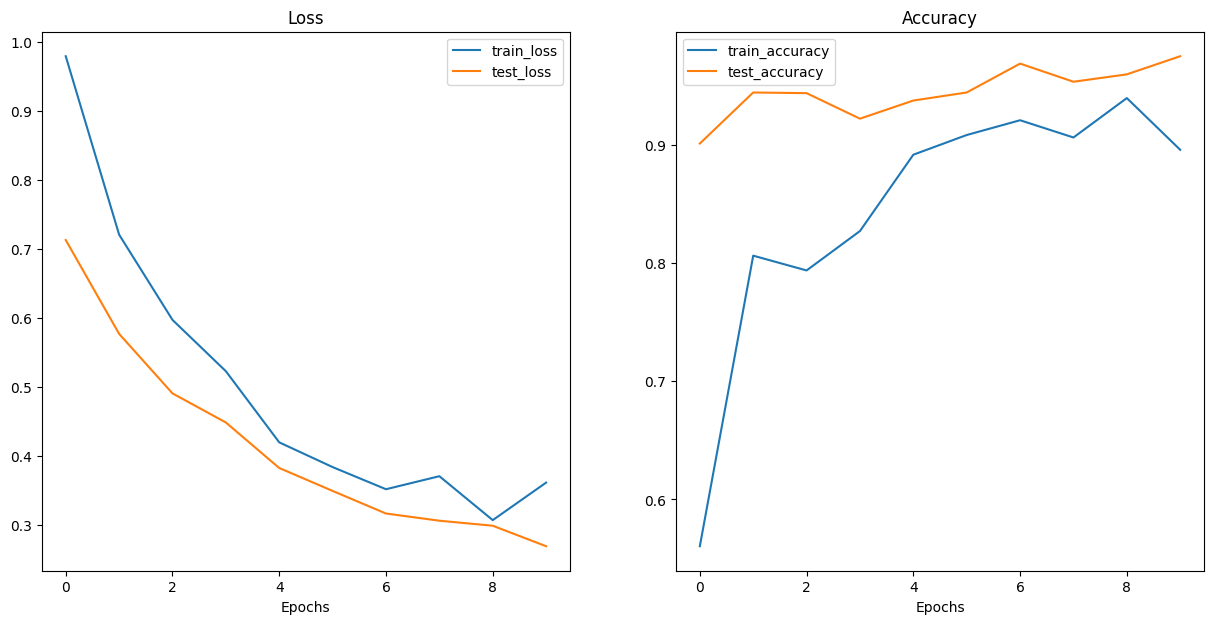

In [ ]:
# Plot loss and accuracy curves
plot_loss_curves(results_effnetb2)

In [ ]:
# Save the model
save_model(model=model_effnetb2,
           target_dir="models",
           model_name="model_effnetb2.pth")

[INFO] Saving model to: models/model_effnetb2.pth


In [ ]:
# Count number of parameters in EffNetB2
model_effnetb2_total_parms = sum(torch.numel(parm) for parm in model_effnetb2.parameters())

# Get the model size in bytes then convert to megabytes
model_size = Path("models/model_effnetb2.pth").stat().st_size // (1024*1024)  # division converts bytes to megabytes (roughly)

# Save statistics
model_effnetb2_stats = {
    "test_loss": min(results_effnetb2['test_loss']),  # save the best loss
    "test_acc": max(results_effnetb2['test_acc']),    # save the best accuracy
    "number_of_parameters": model_effnetb2_total_parms,
    "model_size (MB)": model_size
}
model_effnetb2_stats

{'test_loss': 0.2691518545150757,
 'test_acc': 0.975,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [ ]:
results_effnetb2

{'train_loss': [0.9791007200876872,
  0.7205862045288086,
  0.5970784982045492,
  0.5227160811424255,
  0.41963242888450625,
  0.3838156223297119,
  0.351728884379069,
  0.37060495018959044,
  0.3069563388824463,
  0.36132629215717316],
 'train_acc': [0.5604166666666667,
  0.80625,
  0.79375,
  0.8270833333333333,
  0.8916666666666667,
  0.9083333333333333,
  0.9208333333333333,
  0.90625,
  0.9395833333333333,
  0.8958333333333334],
 'test_loss': [0.712809932231903,
  0.5768577694892884,
  0.49058522582054137,
  0.4484281361103058,
  0.38247734904289243,
  0.34927297830581666,
  0.3165440231561661,
  0.3061124742031097,
  0.2988425940275192,
  0.2691518545150757],
 'test_acc': [0.9011363636363636,
  0.9443181818181818,
  0.94375,
  0.922159090909091,
  0.9375,
  0.9443181818181818,
  0.96875,
  0.953409090909091,
  0.959659090909091,
  0.975]}

In [ ]:
# Save the model locally to my machine
from google.colab import files

model_path = "models/model_effnetb2.pth"  # gets model from here and
#files.download(model_path)                # saves it to my Downloads folder

model_path = "models/effnetb2.pth"  # gets model from here and
#files.download(model_path)          # saves it to my Downloads folder

"""
Why does pretrained_writer.run_model_writer train better than the inline code with the same steps?
I've checked and compared the steps look the same. ??weird
"""

"\nWhy does pretrained_writer.run_model_writer train better than the inline code with the same steps?\nI've checked and compared the steps look the same. ??weird\n"

## 4. Creating a ViT feature extractor

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  """Creates a ViT-B/16 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of target classes. Defaults to 3.
      seed (int, optional): random seed value for output layer. Defaults to 42.

  Returns:
      model (torch.nn.Module): ViT-B/16 feature extractor model.
      transforms (torchvision.transforms): ViT-B/16 image transforms.
  """
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all base layers in the "features" section of the model
  for parm in model.parameters():
    parm.requires_grad = False

  # Change classifier head to suit our needs (this will be trainable)
  set_seeds(seed)
  model.heads = nn.Sequential(
    nn.Linear(in_features=768,           # keep this the same as original model
              out_features=num_classes)  # update to reflect target number of classes
  )

  return model, transforms

In [ ]:
# Create ViT model and transforms
vit_model, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 175MB/s]


In [ ]:
from torchinfo import summary

# Print ViT feature extractor model summary
summary(vit_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
""" 4.1 Create DataLoaders for ViT """
# Set up DataLoaders
from going_modular.data_setup import create_dataloaders

train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

In [ ]:
""" 4.2 Training ViT feature extractor """
# Set up optimizer
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=0.003)

# Set up loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
set_seeds()
vit_results = engine.train(model=vit_model,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

print(f"Max test acc: {max(vit_results['test_acc']):.3f} | Min test loss: {min(vit_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5336 | train_acc: 0.8396 | test_loss: 0.0864 | test_acc: 0.9812
Epoch: 2 | train_loss: 0.1345 | train_acc: 0.9625 | test_loss: 0.0844 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.0830 | train_acc: 0.9792 | test_loss: 0.0628 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.0501 | train_acc: 0.9833 | test_loss: 0.0576 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.0388 | train_acc: 0.9917 | test_loss: 0.0565 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0410 | train_acc: 1.0000 | test_loss: 0.0547 | test_acc: 0.9659
Epoch: 7 | train_loss: 0.0301 | train_acc: 0.9979 | test_loss: 0.0599 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0218 | train_acc: 1.0000 | test_loss: 0.0599 | test_acc: 0.9659
Epoch: 9 | train_loss: 0.0290 | train_acc: 1.0000 | test_loss: 0.0550 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0160 | train_acc: 1.0000 | test_loss: 0.0524 | test_acc: 0.9875
Max test acc: 0.988 | Min test loss: 0.052


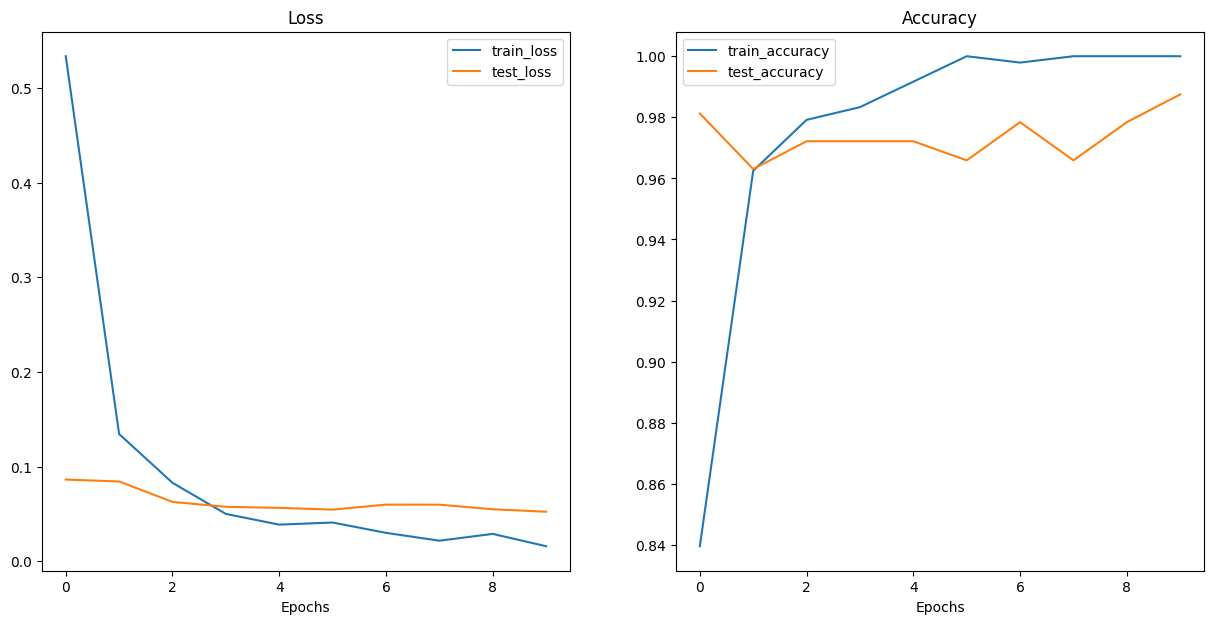

In [ ]:
""" 4.3 Inspecting ViT loss curves """
# Plot loss and accuracy curves
plot_loss_curves(vit_results)

In [ ]:
""" 4.4 Saving ViT feature extractor """
# Save the model
save_model(model=vit_model,
           target_dir="models",
           model_name="vit_model.pth")

[INFO] Saving model to: models/vit_model.pth


In [ ]:
""" 4.5 Checking the size of ViT feature extractor """
# Get the model size in bytes then convert to megabytes
model_size = Path("models/vit_model.pth").stat().st_size // (1024*1024)  # division converts bytes to megabytes (roughly)
print(f"vit_model size: {model_size} MB")

vit_model size: 327 MB


In [ ]:
""" 4.6 Collecting ViT feature extractor stats """
# Count number of parameters in ViT
vit_total_parms = sum(torch.numel(param) for param in vit_model.parameters())

# Create ViT statistics dictionary
vit_stats = {
    "test_loss": min(vit_results["test_loss"]),
    "test_acc": max(vit_results["test_acc"]),
    "number_of_parameters": vit_total_parms,
    "model_size (MB)": model_size
}
vit_stats

{'test_loss': 0.05243474576855078,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [ ]:
# Save the model locally to my machine
from google.colab import files

model_path = "models/vit_model.pth"  # gets model from here and
#files.download(model_path)           # saves it to my Downloads folder

In [ ]:
from going_modular import pretrained_writer

weights_vit = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit = torchvision.models.vit_b_16(weights=weights_vit).to(device)

results_vit, pred_list_vit = pretrained_writer.run_model_writer(
    model=model_vit,
    weights=weights_vit,
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=32,
    dropout=99.9,  # signals to run_model_writer to update model.heads instead of model.classifier
    in_features=768,
    optimizer_type="Adam",
    optimizer_lr=0.003,
    num_epochs=10,
    image_data=test_image_path_list,
    device=device,
    writer=None,
    model_name="model_vit"
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 174MB/s]


Training with model model_vit...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3415 | train_acc: 0.8521 | test_loss: 0.0799 | test_acc: 0.9722
Epoch: 2 | train_loss: 0.0987 | train_acc: 0.9667 | test_loss: 0.0537 | test_acc: 0.9784
Epoch: 3 | train_loss: 0.0666 | train_acc: 0.9792 | test_loss: 0.0598 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.0527 | train_acc: 0.9938 | test_loss: 0.0574 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.0287 | train_acc: 0.9979 | test_loss: 0.0673 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0226 | train_acc: 1.0000 | test_loss: 0.0558 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0276 | train_acc: 1.0000 | test_loss: 0.0546 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0169 | train_acc: 1.0000 | test_loss: 0.0710 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.0224 | train_acc: 1.0000 | test_loss: 0.0680 | test_acc: 0.9659
Epoch: 10 | train_loss: 0.0123 | train_acc: 1.0000 | test_loss: 0.0548 | test_acc: 0.9597
[INFO] Total running time: 96.626 seconds
Predicting with data/pizza_steak_sushi_20_percent/test image_data..

In [ ]:
# Save the model
save_model(model=model_vit,
           target_dir="models",
           model_name="model_vit.pth")

[INFO] Saving model to: models/model_vit.pth


In [ ]:
# Get the model size in bytes then convert to megabytes
model_size = Path("models/model_vit.pth").stat().st_size // (1024*1024)  # division converts bytes to megabytes (roughly)

# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in model_vit.parameters())

# Create ViT statistics dictionary
model_vit_stats = {
    "test_loss": min(results_vit["test_loss"]),
    "test_acc": max(results_vit["test_acc"]),
    "number_of_parameters": vit_total_params,
    "model_size (MB)": model_size
}
model_vit_stats

{'test_loss': 0.05365642769029364,
 'test_acc': 0.978409090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing them

In [ ]:
# Display first 5 test image filepaths
test_image_path_list[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/476333.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2716791.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3138001.jpg')]

In [ ]:
""" Copy the predict_and_store.py function and add prediction time """
import pathlib

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_time_and_store(model: torch.nn.Module,
                        test_paths: List[pathlib.Path],
                        transform: torchvision.transforms,
                        class_names: List[str],
                        device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # Create an empty list to store prediction dictionaries
  pred_list = []

  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Save sample path
    pred_dict["image_path"] = path

    # Save class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Start the prediction timer
    start_time = timer()

    # Open image path
    img = Image.open(path).convert("RGB")  # ensure images are converted to RGB format before applying the default transformations

    # Transform image and add batch dimension
    transformed_image = transform(img).unsqueeze(dim=0).to(device)

    # Prepare model for inference
    model.to(device)
    model.eval()

    # Get prediction probability, predicition label and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image)         # perform inference on target sample
      pred_prob = torch.softmax(pred_logit, dim=1)  # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1)   # turn prediction probabilities into prediction label
      pred_class = class_names[pred_label.cpu()]    # hardcode prediction class to be on CPU

      # Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)  # get the highest pred_prob rounded to 4 places
      pred_dict["pred_class"] = pred_class          # predicted class name

      # End the timer and calculate time per pred
      end_time = timer()
      pred_dict["pred_time"] = round(end_time - start_time, 4)

    # Does the prediction match the true label?
    pred_dict["correct"] = class_name == pred_class

    # Add sample dict to list of preds
    pred_list.append(pred_dict)

  # Return list of prediction dictionaries
  return pred_list

### 5.2 Making and timing predictions with EffNetB2

In [ ]:
# In File Explorer go to 'content' folder and click vertical 3 dots to the right of it, select Upload
!ls

data  going_modular  model_effnetb2.pth  runs  sample_data


In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
class_names = ["pizza", "steak", "sushi"]

# Create a new instance of EfficientNet_B2 (the same class as our saved state_dict())
# Note: loading a model will error if the shapes here aren't the same as the saved version
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_effnetb2 = torchvision.models.efficientnet_b2(weights=weights_b2)

# Modify the classifier head for your specific number of classes (pizza, steak, sushi = 3)
# This needs to be done before loading the state_dict, regardless of the device
in_features = model_effnetb2.classifier[1].in_features                         # Get the number of input features for the classifier layer
model_effnetb2.classifier[1] = torch.nn.Linear(in_features, len(class_names))  # Update the classifier with the correct number of output features

if device == "cuda":
  # Load in the saved state_dict() for gpu
  model_effnetb2.load_state_dict(torch.load(f="model_effnetb2.pth"))
else:
  """
  The model was trained on the GPU, this loads it on the CPU
  """
  # Load in the saved state_dict() for cpu
  model_effnetb2.load_state_dict(torch.load('model_effnetb2.pth',
                                 map_location=torch.device('cpu')))  # map all tensors to the CPU

# Move the model to the appropriate device (not needed in this case as we are already on the correct device)
#model.to(device)
print("Model loaded to", device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 132MB/s]


Model loaded to cpu


In [ ]:
model_effnetb2.classifier[1].in_features

1408

In [ ]:
model_effnetb2.classifier[1]

Linear(in_features=1408, out_features=3, bias=True)

In [ ]:
# Print EffNetB2 model summary
summary(model_effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [ ]:
# Make and time predictions across test dataset with EffNetB2
effnetb2_transforms = weights_b2.transforms()
model_effnetb2_preds = pred_time_and_store(model=model_effnetb2,
                                           test_paths=test_image_path_list,
                                           transform=effnetb2_transforms,
                                           class_names=class_names,
                                           device="cpu")  # make predictions on CPU to replicate user's device

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 2 predictions
model_effnetb2_preds[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9265,
  'pred_class': 'steak',
  'pred_time': 0.4245,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/476333.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9461,
  'pred_class': 'steak',
  'pred_time': 0.1206,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
model_effnetb2_preds_df = pd.DataFrame(model_effnetb2_preds)
model_effnetb2_preds_df.head()

,image_path,class_name,pred_prob,pred_class,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.6970,pizza,0.3861,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9599,pizza,0.1426,True
2,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.6072,pizza,0.1173,True
3,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.7110,pizza,0.1343,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9249,pizza,0.1217,True


In [ ]:
# Check number of correct predictions
model_effnetb2_preds_df.correct.value_counts()

,count
correct,
True,146
False,4


In [ ]:
# Find the average time per prediction
pred_time_mean = round(model_effnetb2_preds_df.pred_time.mean(), 4)
print(f"EffNetB2 average time per prediction: {pred_time_mean} seconds")

EffNetB2 average time per prediction: 0.1384 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
model_effnetb2_stats = {
    "test_loss": 0.2691518545150757,  # save the best loss
    "test_acc": 0.975,                # save the best accuracy
    "number_of_parameters": 7705221,
    "model_size (MB)": 29,
    "avg_pred_time": pred_time_mean
}
model_effnetb2_stats

{'test_loss': 0.2691518545150757,
 'test_acc': 0.975,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'avg_pred_time': np.float64(0.1384)}



```
Compared to first time with unsaved model:
{...
 'avg_pred_time': np.float64(0.1172)}
```



### 5.3 Making and timing predictions with ViT

In [ ]:
# In File Explorer go to 'content' folder and click vertical 3 dots to the right of it, select Upload
!ls

In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
class_names = ["pizza", "steak", "sushi"]

# Create a new instance of ViT_B_16 (the same class as our saved state_dict())
# Note: loading a model will error if the shapes here aren't the same as the saved version
weights_vit = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_model = torchvision.models.vit_b_16(weights=weights_vit)


In [ ]:
vit_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
in_features = vit_model.heads[0].in_features
in_features

768

In [ ]:
vit_model.heads[0].out_features

1000

In [ ]:
# This way looks good here but 3 isn't saved in the Sequential() part of the model (summary still has 768, 1000).
# It also doesn't change Sequential((head): Linear()) to (0): Linear() like we want.
vit_model.heads[0].out_features = len(class_names)
vit_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=3, bias=True)
)

In [ ]:
# Modify the classifier head for your specific number of classes (pizza, steak, sushi = 3)
# This needs to be done before loading the state_dict, regardless of the device
vit_model.heads = nn.Sequential(
    nn.Linear(in_features=in_features,
              out_features=len(class_names))  # Update the classifier with the correct number of output features
)
vit_model.heads

Sequential(
  (0): Linear(in_features=768, out_features=3, bias=True)
)

In [ ]:
if device == "cuda":
  # Load in the saved state_dict() for gpu
  vit_model.load_state_dict(torch.load(f="vit_model.pth"))
else:
  """
  The model was trained on the GPU, this loads it on the CPU
  """
  # Load in the saved state_dict() for cpu
  vit_model.load_state_dict(torch.load('vit_model.pth',
                            map_location=torch.device('cpu')))  # map all tensors to the CPU

# Move the model to the appropriate device (not needed in this case as we are already on the correct device)
#model.to(device)
print("Model loaded to", device)

Model loaded to cpu


In [ ]:
# Print ViT model summary
summary(vit_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [ ]:
# Make and time predictions across test dataset with ViT
vit_transforms = weights_vit.transforms()
model_vit_preds = pred_time_and_store(model=vit_model,
                                      test_paths=test_image_path_list,
                                      transform=vit_transforms,
                                      class_names=class_names,
                                      device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first couple of ViT predictions on the test dataset
model_vit_preds[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/441659.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9993,
  'pred_class': 'pizza',
  'pred_time': 0.9853,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9999,
  'pred_class': 'pizza',
  'pred_time': 0.7577,
  'correct': True}]

In [ ]:
# Turn model_vit_preds in a DataFrame
model_vit_preds_df = pd.DataFrame(model_vit_preds)
model_vit_preds_df.head()

,image_path,class_name,pred_prob,pred_class,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9993,pizza,0.9853,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9999,pizza,0.7577,True
2,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9997,pizza,0.7985,True
3,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9976,pizza,0.7194,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9999,pizza,1.1394,True


In [ ]:
# Count the number of correct predictions
model_vit_preds_df.correct.value_counts()

,count
correct,
True,148
False,2


In [ ]:
# Get average time per prediction for ViT model
pred_time_mean = round(model_vit_preds_df.pred_time.mean(), 4)
print(f"EffNetB2 average time per prediction: {pred_time_mean} seconds")

EffNetB2 average time per prediction: 0.9034 seconds


In [ ]:
# Add ViT average prediction time to stats dictionary
vit_stats = {
    'test_loss': 0.05243474576855078,
    'test_acc': 0.9875,
    'number_of_parameters': 85800963,
    'model_size (MB)': 327,
    'avg_pred_time': pred_time_mean
}
vit_stats

{'test_loss': 0.05243474576855078,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'avg_pred_time': np.float64(0.9034)}



```
Compared to first time with unsaved model:
{...
 'avg_pred_time': np.float64(0.6367)}
```



## 6. Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([model_effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),avg_pred_time,model
0,0.269152,97.50,7705221,29,0.1172,EffNetB2
1,0.052435,98.75,85800963,327,0.6367,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),  # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),avg_pred_time
ViT to EffNetB2 ratios,0.194815,1.012821,11.135432,11.275862,5.432594


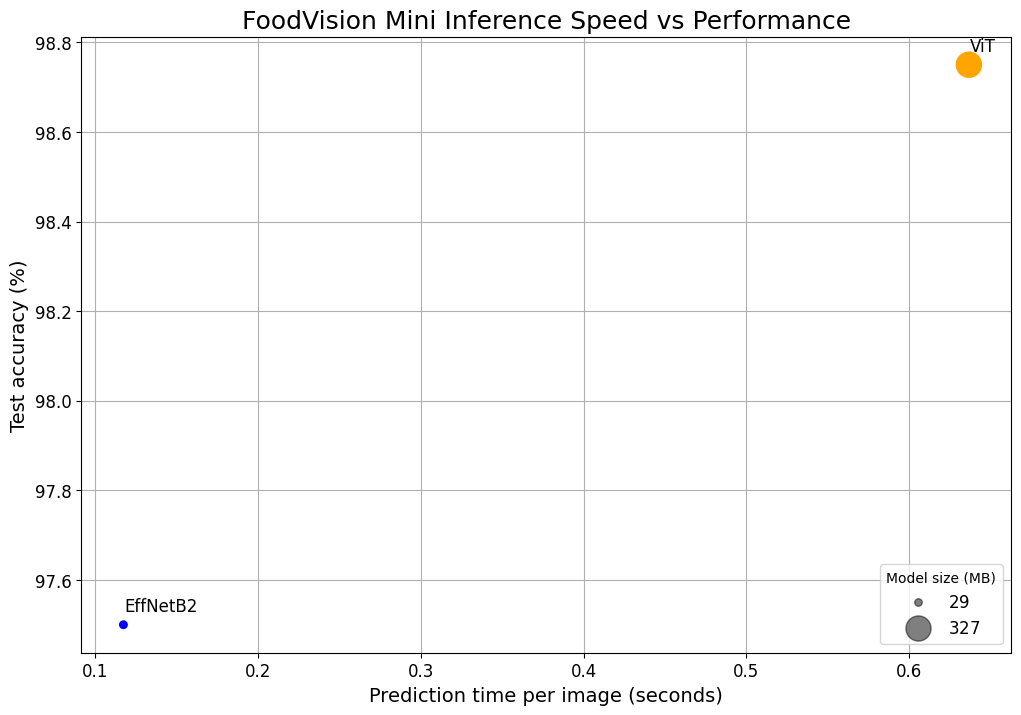

In [ ]:
""" 6.1 Visualizing the speed vs. performance tradeoff """
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="avg_pred_time",
                     y="test_acc",
                     c=["blue", "orange"],  # what colors to use
                     s="model_size (MB)")   # size of the dots by model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["avg_pred_time"]+0.0006, row["test_acc"]+0.03),
              size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
!mkdir images
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()